# Ocean transports and maps

Transports within the climate system are commonly represented as vector fields on a `C-grid`. 

Transports often need to be integrated across a grid path that either (1) connects two points or (2) tracks a closed contour suh as a meridian.

For more about how these methods, please refer to [Forget et al, 2015](https://doi.org/10.5194/gmd-8-3071-2015) _ECCO version 4: An integrated framework for non-linear inverse modeling and global ocean state estimation._

Key functions:
- `LatitudeCircles` computes integration paths that follow latitude circles
- `ThroughFlow` computes transports through these integration paths

### Time average and vertically integrate transports

_note: `trsp_read` reloads intermediate results from file._

In [1]:
using MeshArrays, Plots, Statistics, MITgcmTools

include("prepare_transports.jl")
p=dirname(pathof(MeshArrays))
include(joinpath(p,"../examples/Plots.jl"))

if !isdir("../inputs/GRID_LLC90")
    run(`git clone https://github.com/gaelforget/GRID_LLC90 ../inputs/GRID_LLC90`)
end

mypath="../inputs/GRID_LLC90/"
mygrid=GridSpec("LatLonCap",mypath)

SPM,lon,lat=read_SPM(mypath)
GridVariables=GridLoad(mygrid)
(TrspX, TrspY, TauX, TauY, SSH)=trsp_read(mygrid,mypath);

### Transports between latitude bands

In [2]:
UVmean=Dict("U"=>TrspX,"V"=>TrspY,"dimensions"=>["x","y"]);
LC=LatitudeCircles(-89.0:89.0,GridVariables);

T=Array{Float64,1}(undef,length(LC));
for i=1:length(LC)
   T[i]=ThroughFlow(UVmean,LC[i],GridVariables)
end

### Plot result

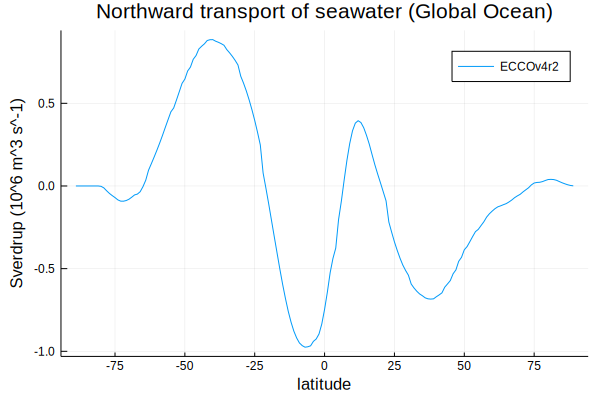

In [3]:
l=-89.0:89.0
plot(l,T/1e6,xlabel="latitude",ylabel="Sverdrup (10^6 m^3 s^-1)",
    label="ECCOv4r2",title="Northward transport of seawater (Global Ocean)")

### Plot transport arrays

_Note that vector field orientations differ amongst the arrays._

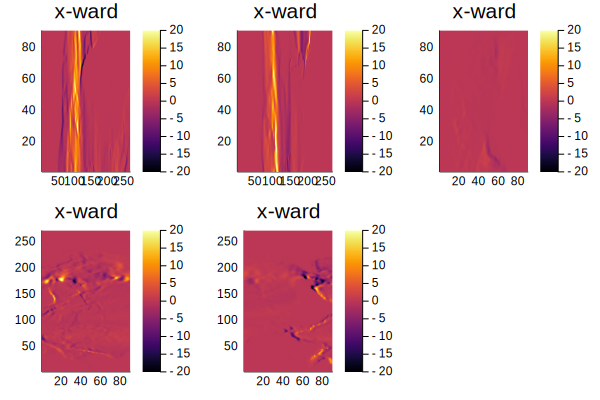

In [4]:
heatmap(1e-6*TrspX,clims=(-20.0,20.0),title="x-ward")
#heatmap(1e-6*TrspY,clims=(-20.0,20.0),title="y-ward")

Convert to `Sv` and mask out land

In [5]:
u=1e-6 .*UVmean["U"]; v=1e-6 .*UVmean["V"];
u[findall(GridVariables["hFacW"][:,1].==0)].=NaN;
v[findall(GridVariables["hFacS"][:,1].==0)].=NaN;

`x/y` transport at cell center

In [6]:
using Statistics
nanmean(x) = mean(filter(!isnan,x))
nanmean(x,y) = mapslices(nanmean,x,dims=y)

(u,v)=exch_UV(u,v);
uC=similar(u); vC=similar(v);
for iF=1:mygrid.nFaces;
    tmp1=u[iF][1:end-1,:]; tmp2=u[iF][2:end,:];
    uC[iF]=reshape(nanmean([tmp1[:] tmp2[:]],2),size(tmp1));
    tmp1=v[iF][:,1:end-1]; tmp2=v[iF][:,2:end];
    vC[iF]=reshape(nanmean([tmp1[:] tmp2[:]],2),size(tmp1));
end

`Eastward/Northward` transport

_Note: compare vector field orientations with previous plot._

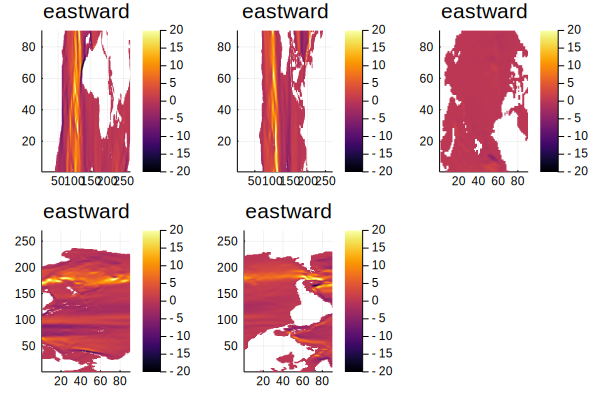

In [7]:
cs=GridVariables["AngleCS"];
sn=GridVariables["AngleSN"];
u=uC.*cs-vC.*sn;
v=uC.*sn+vC.*cs;
heatmap(u,clims=(-20.0,20.0),title="eastward")

### Map out transport 

Here we map out (1) zonal and (2) meridional transport as a function of longitude and latitude.

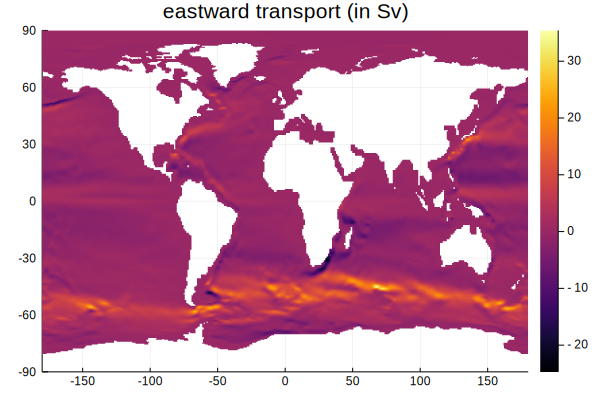

In [8]:
uI=MatrixInterp(write(u),SPM,size(lon))
heatmap(vec(lon[:,1]),vec(lat[1,:]),transpose(uI),
    title="eastward transport (in Sv)")

#vI=MatrixInterp(write(v),SPM,size(lon))
#heatmap(vec(lon[:,1]),vec(lat[1,:]),transpose(vI),
#    title="northward transport per grid cell (in Sv)")